Imports

In [95]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

Input parameters for scraping

In [96]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [97]:
scrap_games(years)

Read data

In [135]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)
print(seasons_games)

{2022:                      start_time              away_team  away_team_score  \
0     2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1     2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2     2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3     2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4     2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   
...                         ...                    ...              ...   
1318  2022-06-06 00:00:00+00:00         BOSTON CELTICS               88   
1319  2022-06-09 01:00:00+00:00  GOLDEN STATE WARRIORS              100   
1320  2022-06-11 01:00:00+00:00  GOLDEN STATE WARRIORS              107   
1321  2022-06-14 01:00:00+00:00         BOSTON CELTICS               94   
1322  2022-06-17 01:00:00+00:00  GOLDEN STATE WARRIORS              103   

                  home_team  home_team_score  
0           MILWAUKEE BUCKS              127 

Edit dataframe

In [136]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())
print(teams)
# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']


['MILWAUKEE BUCKS', 'LOS ANGELES LAKERS', 'CHARLOTTE HORNETS', 'DETROIT PISTONS', 'NEW YORK KNICKS', 'TORONTO RAPTORS', 'MEMPHIS GRIZZLIES', 'MINNESOTA TIMBERWOLVES', 'NEW ORLEANS PELICANS', 'SAN ANTONIO SPURS', 'UTAH JAZZ', 'PORTLAND TRAIL BLAZERS', 'PHOENIX SUNS', 'ATLANTA HAWKS', 'MIAMI HEAT', 'GOLDEN STATE WARRIORS', 'ORLANDO MAGIC', 'WASHINGTON WIZARDS', 'CLEVELAND CAVALIERS', 'PHILADELPHIA 76ERS', 'BOSTON CELTICS', 'HOUSTON ROCKETS', 'CHICAGO BULLS', 'DENVER NUGGETS', 'SACRAMENTO KINGS', 'INDIANA PACERS', 'LOS ANGELES CLIPPERS', 'BROOKLYN NETS', 'OKLAHOMA CITY THUNDER', 'DALLAS MAVERICKS']


Show data (first 5 rows)

In [137]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

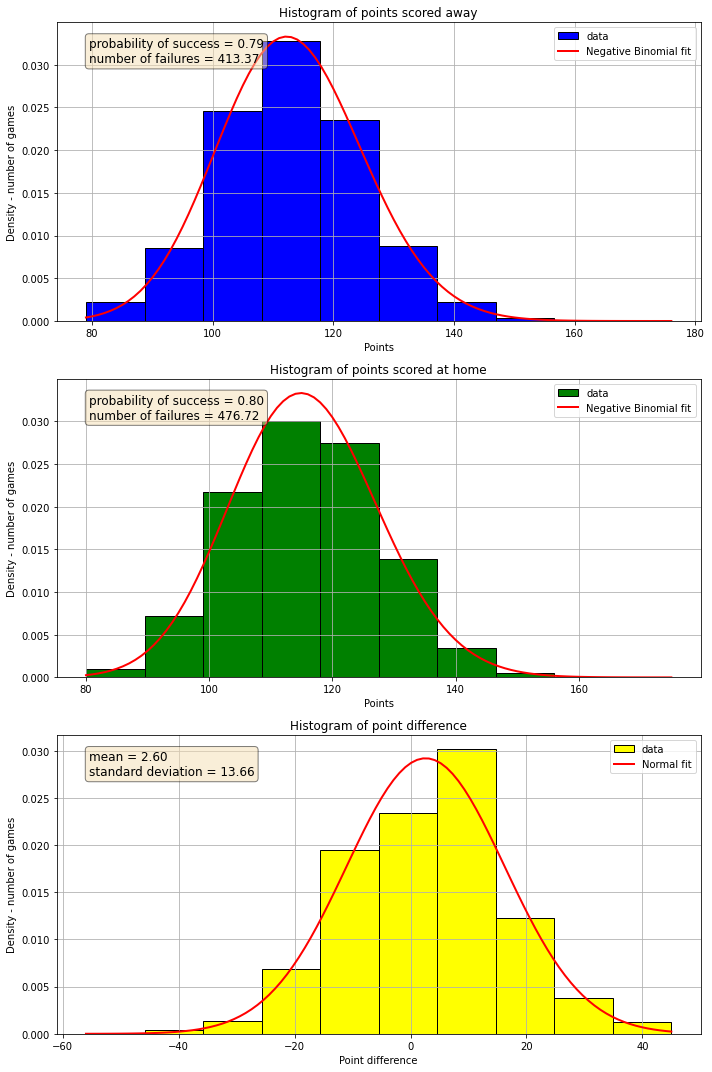

In [138]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    if col == 'difference':
        std = np.sqrt(var)
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'probability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [139]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

Modelling

Model 2 - poisson

Predicting

In [140]:
with open('src/model/model_2.stan', 'r') as f:
    print(f.read())

data {
  int teams_number;
  int games_number;
  array[games_number] int home_team;
  array[games_number] int away_team;
  array[games_number] int<lower=0> home_score;
  array[games_number] int<lower=0> away_score;
}
parameters {
  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real<lower=0> sigma2_att;
  real<lower=0> sigma2_def;

  vector[teams_number-1] home_att_raw;
  vector[teams_number-1] away_att_raw;
  vector[teams_number-1] home_def_raw;
  vector[teams_number-1] away_def_raw;
}
transformed parameters {
  vector[games_number] log_mu_home;
  vector[games_number] log_mu_away;
  vector[teams_number] home_att;
  vector[teams_number] away_att;
  vector[teams_number] home_def;
  vector[teams_number] away_def;

  // need to make sum(att)=sum(def)=0
  for (k in 1:(teams_number-1)) {
    home_att[k] = home_att_raw[k];
    away_att[k] = away_att_raw[k];
    home_def[k] = home_def_raw[k];
    away_def[k] = away_att_raw[k];
  }
  home_att[teams_number] = -s

In [141]:
model_2 = CmdStanModel(stan_file='src/model/model_2.stan')
samples = 1000
sim=model_2.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=False,
                     refresh=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [142]:
mod_2 = sim.draws_pd()
mod_2.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_home_att,mu_away_att,mu_home_def,...,away_def[21],away_def[22],away_def[23],away_def[24],away_def[25],away_def[26],away_def[27],away_def[28],away_def[29],away_def[30]
0,-19163.0,0.0,14.3855,0.0,1.0,1.0,19231.0,1.29692,0.628161,1.36913,...,0.428577,0.059311,1.97765,0.948437,1.58217,-1.33264,0.932971,-0.248966,1.26604,-8.26429
1,-19163.0,0.0,14.3855,0.0,1.0,1.0,19227.0,1.29692,0.628161,1.36913,...,0.428577,0.059311,1.97765,0.948437,1.58217,-1.33264,0.932971,-0.248966,1.26604,-8.26429
2,-19163.0,0.0,14.3855,0.0,1.0,1.0,19220.5,1.29692,0.628161,1.36913,...,0.428577,0.059311,1.97765,0.948437,1.58217,-1.33264,0.932971,-0.248966,1.26604,-8.26429
3,-19163.0,0.0,14.3855,0.0,1.0,1.0,19217.0,1.29692,0.628161,1.36913,...,0.428577,0.059311,1.97765,0.948437,1.58217,-1.33264,0.932971,-0.248966,1.26604,-8.26429
4,-19163.0,0.0,14.3855,0.0,1.0,1.0,19220.3,1.29692,0.628161,1.36913,...,0.428577,0.059311,1.97765,0.948437,1.58217,-1.33264,0.932971,-0.248966,1.26604,-8.26429


2023


/tmp/ipykernel_5265/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


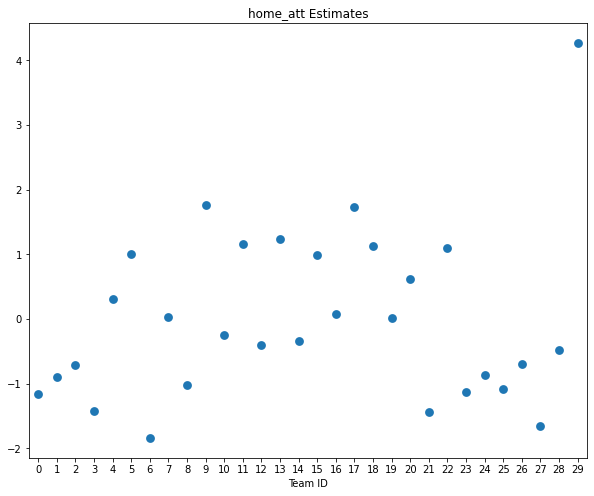

/tmp/ipykernel_5265/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


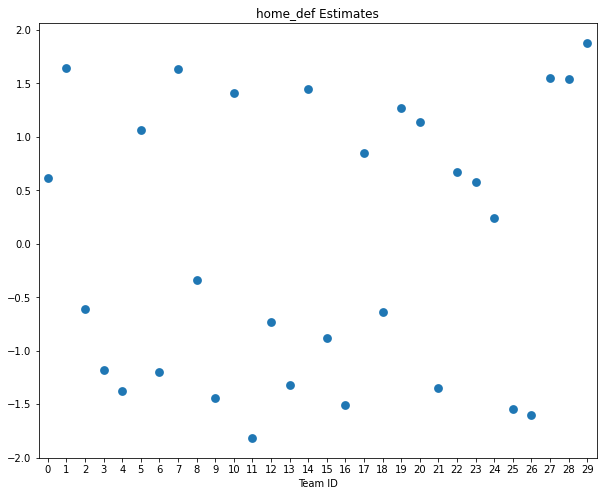

/tmp/ipykernel_5265/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


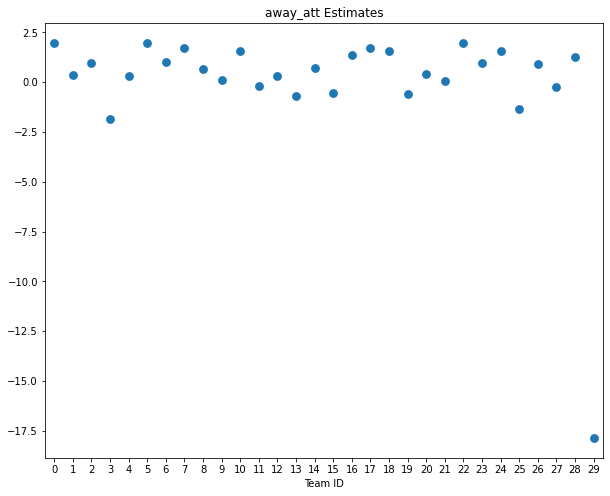

/tmp/ipykernel_5265/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


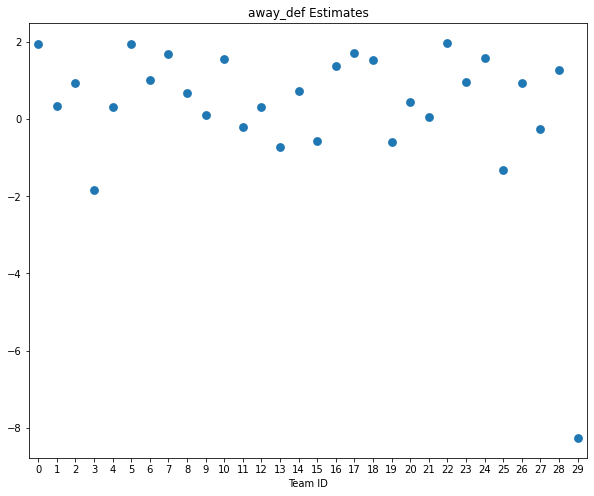

In [143]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
print(year)
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams)))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

In [147]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
param_dict = {param: sim.stan_variable(param) for param in parameters}

# Przykładowe dane do przewidywania (przykładowe ID drużyn)

season_games_pred1 = {2023: seasons_games[2023][-20:]}

# Przewidywanie wyników dla każdego meczu
for idx, row in season_games_pred1[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    home_score = row['home_team_score']
    away_score = row['away_team_score']
    
    # Pobieranie odpowiednich parametrów dla drużyn
    home_att = param_dict['home_att'][:, home_idx-1]
    home_def = param_dict['home_def'][:, away_idx-1]
    away_att = param_dict['away_att'][:, home_idx-1]
    away_def = param_dict['away_def'][:, away_idx-1]
    
    # Tworzenie parametrów log_mu
    log_mu1 = home_att + away_def + np.log(home_score)
    log_mu2 = home_def + away_att + np.log(away_score)
    
    # Symulowanie z rozkładu Poissona dla uzyskania predyktywnej dystrybucji
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    print(y1[0:10], y2[0:10])
    # draw blocked
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    
    # Obliczanie prawdopodobieństw wyników
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [np.mean(y1 > y2)],
        'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
    print(outcome_probabilities)

[176 163 182 180 175 155 190 171 181 180] [282 318 280 268 287 291 300 290 320 294]
   home_team_win_prob  away_team_win_prob
0                 0.0                 1.0
[ 88  87  90  83  95  98  85  90  75 118] [34 39 42 43 47 46 54 48 42 40]
   home_team_win_prob  away_team_win_prob
0                 1.0                 0.0
[20 31 32 32 31 21 27 19 22 32] [69 58 43 65 62 67 59 50 66 72]
   home_team_win_prob  away_team_win_prob
0                 0.0                 1.0
[148 137 110 110 126 101 111  99 117 110] [490 455 510 502 469 490 492 448 436 477]
   home_team_win_prob  away_team_win_prob
0                 0.0                 1.0
[58 72 58 62 53 62 59 66 52 74] [1703 1662 1670 1686 1706 1647 1707 1693 1657 1737]
   home_team_win_prob  away_team_win_prob
0                 0.0                 1.0
[440 462 466 437 465 470 459 479 444 417] [819 841 829 806 832 822 829 789 827 828]
   home_team_win_prob  away_team_win_prob
0                 0.0                 1.0
[42 46 46 53 56 56 50 

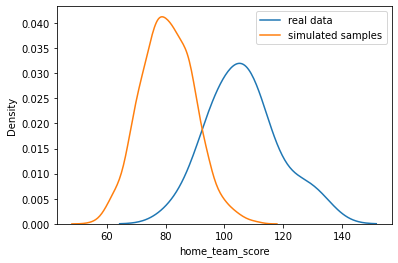

In [151]:
sns.kdeplot(data=season_games_pred1[2023], x='home_team_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

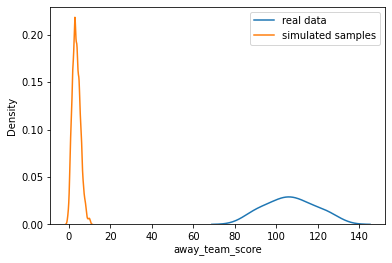

In [152]:
sns.kdeplot(data=season_games_pred1[2023], x='away_team_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()

## Model 3 - poisson

In [ ]:
model_3 = CmdStanModel(stan_file='src/model/model_3.stan')
samples = 1000
sim3=model_3.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=False,
                     refresh=samples)

INFO:cmdstanpy:compiling stan file /app/src/model/model_3.stan to exe file /app/src/model/model_3
INFO:cmdstanpy:compiled model executable: /app/src/model/model_3
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [ ]:
mod_3 = sim3.draws_pd()
mod_3.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_att,mu_def,sigma_att,...,log_mu_away[1314],log_mu_away[1315],log_mu_away[1316],log_mu_away[1317],log_mu_away[1318],log_mu_away[1319],log_mu_away[1320],log_mu_away[1321],log_mu_away[1322],log_mu_away[1323]
0,387580.0,0.0,14.3855,0.0,1.0,1.0,-387551.0,-0.683274,1.57551,0.57659,...,4.03601,0.599947,2.28196,4.03601,3.62352,3.62352,-0.608534,-0.608534,3.62352,-0.608534
1,387580.0,0.0,14.3855,0.0,1.0,1.0,-387547.0,-0.683274,1.57551,0.57659,...,4.03601,0.599947,2.28196,4.03601,3.62352,3.62352,-0.608534,-0.608534,3.62352,-0.608534
2,387580.0,0.0,14.3855,0.0,1.0,1.0,-387556.0,-0.683274,1.57551,0.57659,...,4.03601,0.599947,2.28196,4.03601,3.62352,3.62352,-0.608534,-0.608534,3.62352,-0.608534
3,387580.0,0.0,14.3855,0.0,1.0,1.0,-387544.0,-0.683274,1.57551,0.57659,...,4.03601,0.599947,2.28196,4.03601,3.62352,3.62352,-0.608534,-0.608534,3.62352,-0.608534
4,387580.0,0.0,14.3855,0.0,1.0,1.0,-387551.0,-0.683274,1.57551,0.57659,...,4.03601,0.599947,2.28196,4.03601,3.62352,3.62352,-0.608534,-0.608534,3.62352,-0.608534


In [153]:
season_games_pred2 = {2023: seasons_games[2023][-20:]}

# Number of samples for simulation
samples = 1000

# Extracting parameters from the Stan result
parameters = ['attack', 'defense', 'home_advantage']
param_dict = {param: sim3.stan_variable(param) for param in parameters}

# Predicting results for each game
for idx, row in season_games_pred2[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    
    # Retrieving appropriate parameters for the teams
    home_att = param_dict['attack'][:, home_idx-1]
    home_def = param_dict['defense'][:, home_idx-1]
    away_att = param_dict['attack'][:, away_idx-1]
    away_def = param_dict['defense'][:, away_idx-1]
    home_advantage = param_dict['home_advantage']
    
    # Creating log_mu parameters
    log_mu1 = home_advantage + home_att - away_def
    log_mu2 = away_att - home_def
    
    # Simulating from Poisson distribution to obtain predictive distribution
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    
    # Blocking draws
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    print(y1[0:10], y2[0:10])
    # Calculating outcome probabilities
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [np.mean(y1 > y2)],
        'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
    # Printing results
    print(f"Game {idx + 1}:")
    print(outcome_probabilities)
    print(f"Home Team Points Distribution: {np.mean(y1)} ± {np.std(y1)}")
    print(f"Away Team Points Distribution: {np.mean(y2)} ± {np.std(y2)}\n")

[102  96 101  96  90  98 110  87 102  70] [0 0 0 0 0 1 0 0 0 1]
Game 1301:
   home_team_win_prob  away_team_win_prob
0                 1.0                 0.0
Home Team Points Distribution: 100.896 ± 10.235193403155604
Away Team Points Distribution: 0.356 ± 0.5892910995424928

[215 205 230 221 211 203 220 212 216 203] [16 14 14 11 16 14 19 13 15  9]
Game 1302:
   home_team_win_prob  away_team_win_prob
0                 1.0                 0.0
Home Team Points Distribution: 213.331 ± 13.933249405648347
Away Team Points Distribution: 14.805 ± 3.791434425121975

[438 436 444 422 396 425 407 418 412 393] [1 0 0 0 0 0 0 0 0 0]
Game 1303:
   home_team_win_prob  away_team_win_prob
0                 1.0                 0.0
Home Team Points Distribution: 411.907 ± 20.348964371682406
Away Team Points Distribution: 0.166 ± 0.40055461550205607

[86 87 93 78 76 90 79 80 88 99] [4 1 3 1 5 2 1 1 6 3]
Game 1304:
   home_team_win_prob  away_team_win_prob
0                 1.0                 0.0
Home T

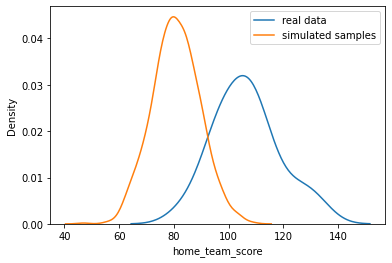

In [154]:
sns.kdeplot(data=season_games_pred2[2023], x='home_team_score', label='real data')
sns.kdeplot(data=y1, label='simulated samples')
plt.legend(loc='best')
plt.show()

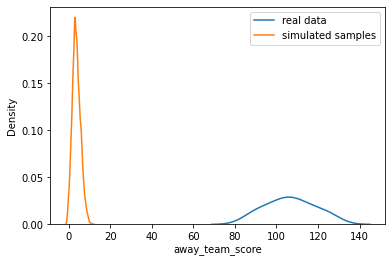

In [155]:
sns.kdeplot(data=season_games_pred1[2023], x='away_team_score', label='real data')
sns.kdeplot(data=y2, label='simulated samples')
plt.legend(loc='best')
plt.show()